In [1]:
import pandas as pd
import json
import numpy as np
from datetime import date 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import qqplot
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,UserWarning,RuntimeWarning))

In [2]:
raw_data=pd.read_json("https://api.covid19india.org/raw_data.json")

In [3]:
raw_data.head(5)

,raw_data
0,"{'agebracket': '20', 'backupnotes': 'Student f..."
1,"{'agebracket': '', 'backupnotes': 'Student fro..."
2,"{'agebracket': '', 'backupnotes': 'Student fro..."
3,"{'agebracket': '45', 'backupnotes': 'Travel hi..."
4,"{'agebracket': '24', 'backupnotes': 'Travel hi..."


In [4]:
c_data = pd.json_normalize(raw_data['raw_data'])

In [5]:
#Remove Blank Rows
c_data_clean=c_data[c_data.detectedstate!=""].copy()

In [6]:
#Format announced date into datetime for index
c_data_clean['dateannounced']=pd.to_datetime(c_data_clean['dateannounced'],format='%d/%m/%Y')

In [7]:
#Sample Data
c_data_clean.tail(5)

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,estimatedonsetdate,gender,nationality,notes,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
13622,,,,Hospitalized,2020-04-17,,S.P.S. Nellore,Andhra Pradesh,,,,Details awaited,13623,https://twitter.com/ArogyaAndhra/status/125103...,,,AP,,17/04/2020,
13623,,,,Hospitalized,2020-04-17,,S.P.S. Nellore,Andhra Pradesh,,,,Details awaited,13624,https://twitter.com/ArogyaAndhra/status/125103...,,,AP,,17/04/2020,
13624,,,,Hospitalized,2020-04-17,,S.P.S. Nellore,Andhra Pradesh,,,,Details awaited,13625,https://twitter.com/ArogyaAndhra/status/125103...,,,AP,,17/04/2020,
13625,,,,Hospitalized,2020-04-17,,S.P.S. Nellore,Andhra Pradesh,,,,Details awaited,13626,https://twitter.com/ArogyaAndhra/status/125103...,,,AP,,17/04/2020,
13626,,,,Hospitalized,2020-04-17,,,Andaman and Nicobar Islands,,,,,13627,https://twitter.com/ChetanSanghi/status/125103...,,,AN,,17/04/2020,


In [8]:
c_data_clean['detectedstate']=c_data_clean['detectedstate'].astype('category')

In [9]:
#Dummy variable
c_data_clean['Total Cases']=1

In [10]:
daily_cases_state_wise=c_data_clean.pivot_table(index=['dateannounced'],columns='detectedstate',values='Total Cases',aggfunc=np.sum).fillna(int(0)).sort_index()

In [11]:
daily_cases_total=pd.DataFrame({'Total':daily_cases_state_wise.sum(axis=1)})

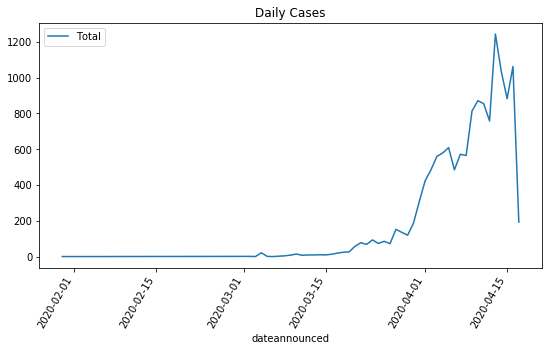

In [12]:
daily_cases_total.plot.line(figsize=(9,5),rot=60,title='Daily Cases')

In [13]:
ci_l=0-1.96*np.sqrt(1/daily_cases_total.shape[0])
ci_m=0+1.96*np.sqrt(1/daily_cases_total.shape[0])
print("95% Confidence Interval for true correlation coefficient: ", ci_l," to ", ci_m)

95% Confidence Interval for true correlation coefficient:  -0.27718585822512665  to  0.27718585822512665


***Autocorrelation Test***

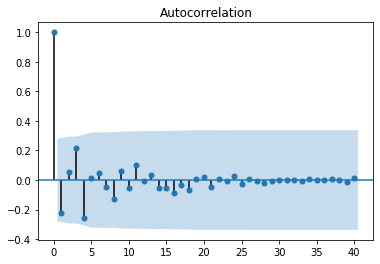

In [14]:
display(fig = sm.graphics.tsa.plot_acf(daily_cases_total.diff().dropna().values.squeeze(), lags=40))

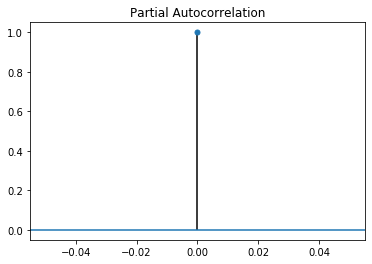

In [15]:
display(fig = sm.graphics.tsa.plot_pacf(daily_cases_total.diff(), lags=40))

In [16]:
print("Difference Level, d = 1")

Difference Level, d = 1


***Auto Regression Model***

In [17]:
from statsmodels.tsa.ar_model import AutoReg
ar_mod = sm.tsa.AutoReg(daily_cases_total,lags=[1,4]).fit()

In [18]:
print(ar_mod.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Total   No. Observations:                   50
Model:              Restr. AutoReg(4)   Log Likelihood                -297.104
Method:               Conditional MLE   S.D. of innovations            154.445
Date:                Fri, 17 Apr 2020   AIC                             10.254
Time:                        12:36:57   BIC                             10.413
Sample:                             4   HQIC                            10.313
                                   50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.8965     29.549      1.079      0.280     -26.019      89.812
Total.L1       1.2040      0.196      6.135      0.000       0.819       1.589
Total.L4      -0.3841      0.226     -1.702      0.0

***Find the Suitable ARIMA Model***

In [19]:
from statsmodels.tsa.arima_model import ARIMA
for d in range (0,3):  
    for p in range (0,5):
        for q in range (0,5):
            try:
                arima_mod = ARIMA(daily_cases_total, (p,d,q)).fit()
                print("(p,d,q): (",p,d,q,") | AIC:",arima_mod.aic, " | Residual Mean:",arima_mod.resid.mean())
            except:
                print(p,d,q," : Not Fit",)

(p,d,q): ( 0 0 0 ) | AIC: 731.6301932986898  | Residual Mean: -2.2737367544323206e-13
(p,d,q): ( 0 0 1 ) | AIC: 689.9010329280106  | Residual Mean: -0.5040484959194373
(p,d,q): ( 0 0 2 ) | AIC: 676.5251225666445  | Residual Mean: -2.78458577174702
(p,d,q): ( 0 0 3 ) | AIC: 659.543582215183  | Residual Mean: -1.7983497948055924
0 0 4  : Not Fit
(p,d,q): ( 1 0 0 ) | AIC: 653.1104520876274  | Residual Mean: 4.075619927968348
(p,d,q): ( 1 0 1 ) | AIC: 652.6312806046551  | Residual Mean: 7.977124551347085
(p,d,q): ( 1 0 2 ) | AIC: 648.0399779104291  | Residual Mean: 2.636116197686215
(p,d,q): ( 1 0 3 ) | AIC: 667.9126234258654  | Residual Mean: 18.710301889248395
(p,d,q): ( 1 0 4 ) | AIC: 926.5833330887929  | Residual Mean: -2285.4431998060304
(p,d,q): ( 2 0 0 ) | AIC: 650.8817481483472  | Residual Mean: 9.092664797148782
(p,d,q): ( 2 0 1 ) | AIC: 652.8550743678168  | Residual Mean: 8.826816951394163
(p,d,q): ( 2 0 2 ) | AIC: 649.7146685303578  | Residual Mean: 3.44077814256847
(p,d,q): ( 2

Suitable ARIMA Model - 1,1,1

***Apply ARIMA Model***

In [20]:
arima_mod = ARIMA(daily_cases_total, (1,1,1)).fit()

***ARIMA Model Residuals***

In [21]:
print("Residual Mean: ",arima_mod.resid.mean())
print("Residual Variance: ",arima_mod.resid.var())

Residual Mean:  -0.12437152201828072
Residual Variance:  22463.575666387158


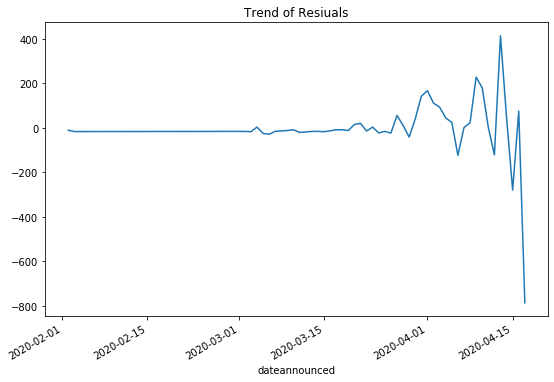

In [22]:
arima_mod.resid.plot(title='Trend of Resiuals',figsize=[9,6])

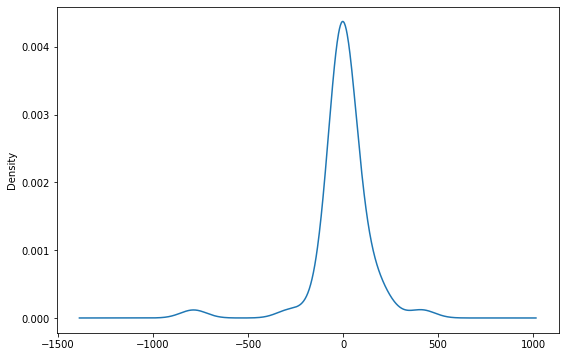

In [23]:
arima_mod.resid.plot(kind='kde', figsize=[9,6])

***Predictions of historic data by the model***

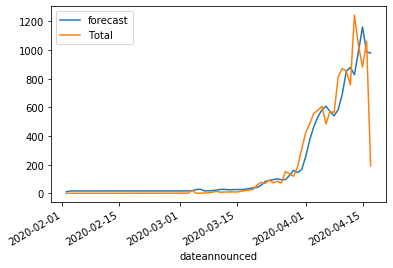

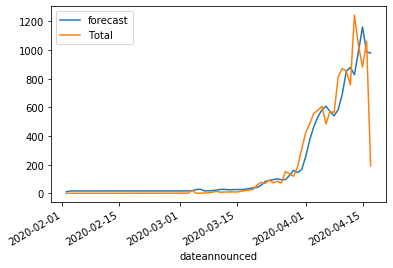

In [24]:
arima_mod.plot_predict()

***Forecast for Next 90 Days***

In [25]:
arima_model_forecasts = arima_mod.forecast(90)

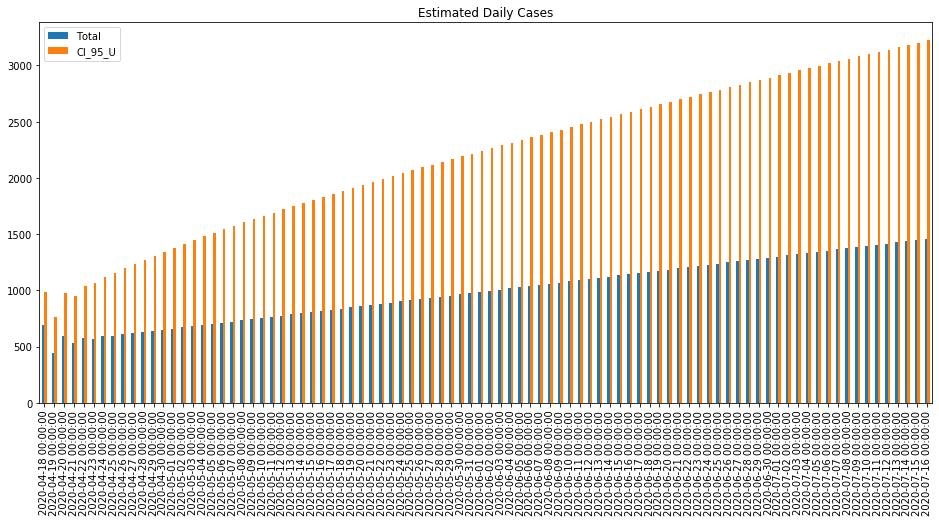

In [26]:
daily_cases_forecast = pd.DataFrame({'Total':arima_model_forecasts[0].transpose(),
                                    'Standard Error':arima_model_forecasts[1].transpose(),
                                    'CI_95_L':arima_model_forecasts[2].transpose()[0],
                                   'CI_95_U':arima_model_forecasts[2].transpose()[1]})
daily_cases_forecast.index=pd.date_range(start='2020-04-18', periods=90,freq='D')
daily_cases_forecast[['Total','CI_95_U']].plot.bar(figsize=[16,7], title='Estimated Daily Cases')

In [27]:
daily_cases_total=daily_cases_total.append(daily_cases_forecast)

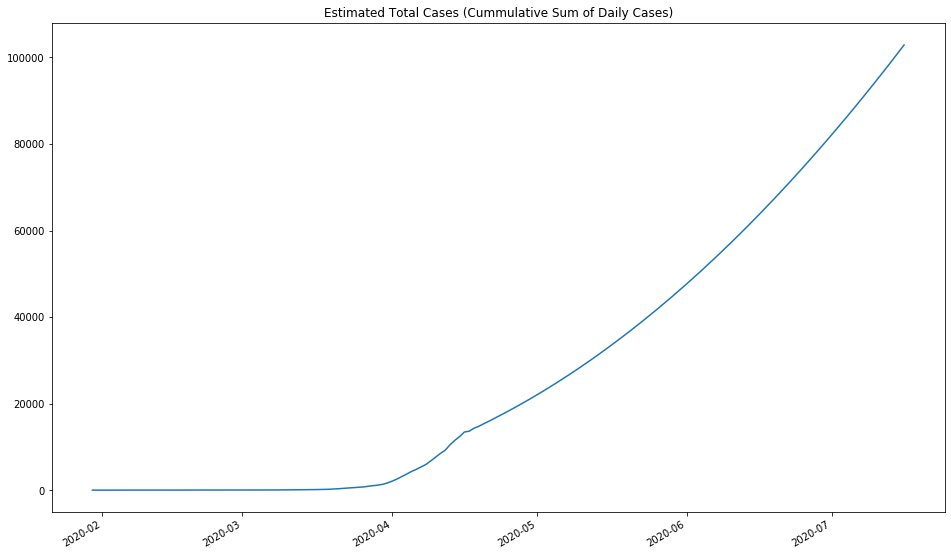

In [28]:
daily_cases_total['Total'].cumsum().plot(title='Estimated Total Cases (Cummulative Sum of Daily Cases)',figsize=[16,10])